Time-Series Forecasting using RNNs

## Step 1: Data exploration and preprocessing

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import time
import random
import optuna

### Setting Random Seed

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1.0,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1.0,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1.0,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1.0,-74.010040,40.719971,-74.012268,40.706718,N,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1.0,-73.973053,40.793209,-73.972923,40.782520,N,435.0


In [5]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
df = pd.concat([train_df, test_df])

### Dataset Statistics

In [7]:
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")
print("\nTrain Column names:")
print(df.columns.tolist())

Number of samples: 1235124
Number of features: 11

Train Column names:
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [8]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.235124e+06,1.235123e+06,1.235123e+06,1.235123e+06,1.235123e+06,1.235123e+06,6.099890e+05
mean,1.534634e+00,1.662471e+00,-7.397358e+01,4.075095e+01,-7.397343e+01,4.075182e+01,9.510465e+02
std,4.987993e-01,1.311854e+00,5.929051e-02,3.158774e-02,5.858375e-02,3.549666e-02,3.979546e+03
min,1.000000e+00,0.000000e+00,-1.219331e+02,3.471223e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073737e+01,-7.399133e+01,4.073595e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075410e+01,-7.397976e+01,4.075451e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396737e+01,4.076837e+01,-7.396301e+01,4.076982e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.924892e+01,5.188108e+01,-6.749680e+01,4.885760e+01,1.939736e+06


<span style='color:green'>

* The dataset represents **taxi trip records in New York City**, capturing information about each trip such as **pickup and dropoff times, locations, passenger count, and trip duration**. 
* It was sourced from the **NYC Taxi and Limousine Commission (TLC)** and is available on platforms like **Kaggle**. 
    
**Key variables** 
* pickup_datetime (timestamp of when the trip started)
* dropoff_datetime (when the trip ended)
* trip_duration (duration of the trip in seconds)
* pickup_longitude
* pickup_latitude
* dropoff_longitude
* dropoff_latitude
* passenger_count  

**Link to dataset:** [NYC Taxi Trip Duration on Kaggle](https://www.kaggle.com/c/nyc-taxi-trip-duration)


</span>

In [9]:
df.isnull().sum()

id                         0
vendor_id                  0
pickup_datetime            0
dropoff_datetime      625135
passenger_count            1
pickup_longitude           1
pickup_latitude            1
dropoff_longitude          1
dropoff_latitude           1
store_and_fwd_flag         1
trip_duration         625135
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235124 entries, 0 to 625133
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1235124 non-null  object 
 1   vendor_id           1235124 non-null  int64  
 2   pickup_datetime     1235124 non-null  object 
 3   dropoff_datetime    609989 non-null   object 
 4   passenger_count     1235123 non-null  float64
 5   pickup_longitude    1235123 non-null  float64
 6   pickup_latitude     1235123 non-null  float64
 7   dropoff_longitude   1235123 non-null  float64
 8   dropoff_latitude    1235123 non-null  float64
 9   store_and_fwd_flag  1235123 non-null  object 
 10  trip_duration       609989 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 113.1+ MB


<span style='color:green;'>We drop the trip_duration and dropoff_datetime as we are planning to detect the trip count over a time series and these columns can be omitted.</span>

In [11]:
df.drop(columns=['trip_duration','dropoff_datetime'],inplace=True)
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235123 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1235123 non-null  object 
 1   vendor_id           1235123 non-null  int64  
 2   pickup_datetime     1235123 non-null  object 
 3   passenger_count     1235123 non-null  float64
 4   pickup_longitude    1235123 non-null  float64
 5   pickup_latitude     1235123 non-null  float64
 6   dropoff_longitude   1235123 non-null  float64
 7   dropoff_latitude    1235123 non-null  float64
 8   store_and_fwd_flag  1235123 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 94.2+ MB


<span style='color:green'>We are now aggregate the trip count on an hourly basis to begin with my task</span>

In [17]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [18]:
time_series = df.set_index('pickup_datetime').resample('H').size()
time_series = time_series.rename('trip_count').reset_index()

In [19]:
time_series

,pickup_datetime,trip_count
0,2016-01-01 00:00:00,453
1,2016-01-01 01:00:00,502
2,2016-01-01 02:00:00,454
3,2016-01-01 03:00:00,422
4,2016-01-01 04:00:00,252
...,...,...
4363,2016-06-30 19:00:00,369
4364,2016-06-30 20:00:00,365
4365,2016-06-30 21:00:00,444
4366,2016-06-30 22:00:00,375


## Visualization - 1 (Trip Count per Hour)

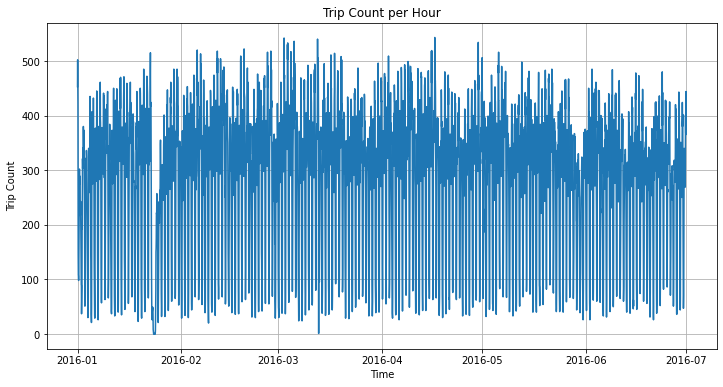

In [106]:
plt.figure(figsize=(12, 6))
plt.plot(time_series['pickup_datetime'], time_series['trip_count'])
plt.title('Trip Count per Hour')
plt.xlabel('Time')
plt.ylabel('Trip Count')
plt.grid()
plt.show()

<span style='color:green'>

This plot illustrates the number of trips recorded per hour from **January 2016 to June 2016**. The following patterns can be observed:

- **Seasonality:** The repeated peaks and troughs suggest a potential daily or weekly pattern in trip demand.
- **Stability:** Despite fluctuations, the overall level of trips appears relatively stable over time.
- **Outliers:** Occasional dips to near-zero trip counts might indicate data gaps or unusual events.

Understanding these patterns can help in **time series forecasting** to predict future trip counts based on historical data.
</span>

## Visualization - 2 (Hourly Average Trip Duration)

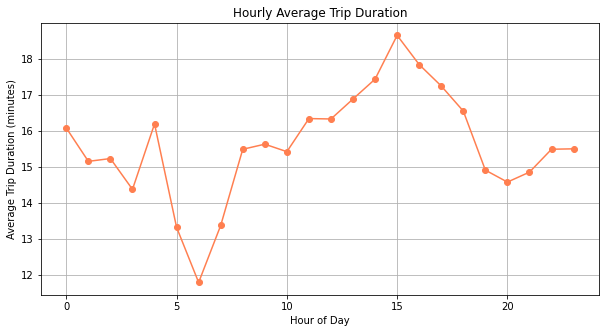

In [22]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['trip_duration'] = train_df['trip_duration'] / 60  # Convert duration to minutes
avg_dur = train_df.groupby(train_df['pickup_datetime'].dt.hour)['trip_duration'].mean()

plt.figure(figsize=(10, 5))
plt.plot(avg_dur.index, avg_dur.values, marker='o', linestyle='-', color='coral')
plt.title('Hourly Average Trip Duration')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.grid()
plt.show()

<span style='color:green'>
This plot illustrates the average trip duration per hour of the day:

- **Morning Dip:** There is a noticeable drop around **5 AM**, which could be due to **less traffic** or more **direct routes**.
- **Morning Peak:** An increase in trip duration is observed after **6 AM**, likely aligning with **morning rush hour** traffic.
- **Afternoon Peak:** The trip duration peaks around **3 PM to 4 PM**, indicating **high traffic or longer trips** during these hours.
- **Evening Drop:** A decline in trip duration after the afternoon peak suggests **traffic eases** as the day progresses.
- **Nighttime Stability:** During late-night hours, trip durations appear **stable**, possibly due to **consistent travel conditions**.

These patterns highlight the **impact of traffic congestion** and **time of day** on trip durations, providing valuable insights for **time series forecasting** and **traffic management**.
</span>

## Visualization - 3 (Autocorrelation Plot for Trip Count (Sample))

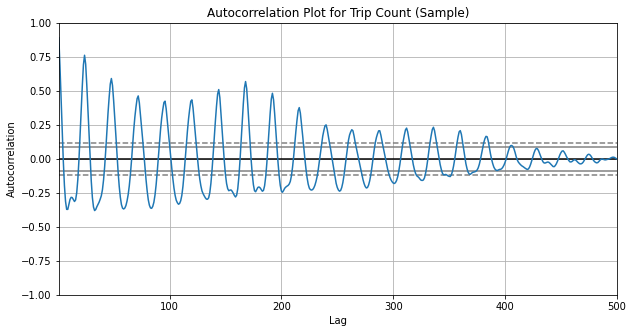

In [108]:
plt.figure(figsize=(10, 5))
autocorrelation_plot(time_series['trip_count'][:500])  # Use first 500 data points to reduce memory usage
plt.title('Autocorrelation Plot for Trip Count (Sample)')
plt.show()

<span style='color:green'>
This plot illustrates the autocorrelation function (ACF) for the trip count data:

- **Seasonality:** The **periodic peaks and troughs** indicate a possible **seasonal pattern**, suggesting that trip counts may follow a **daily or weekly cycle**.
- **Significant Lags:** Peaks that cross the **dashed significance bounds** imply that certain lagged values have a **statistically significant correlation** with current trip counts.
- **Alternating Correlations:** The **positive and negative peaks** suggest both **increases and decreases** in trip counts over time, aligning with a **cyclical pattern**.
- **Stationarity Check:** The slow decay in autocorrelation may indicate that the data is **non-stationary** and may require **differencing** for effective time series modeling.

Understanding these patterns helps in choosing appropriate **time series models** and **forecasting methods** for trip count prediction.
</span>

<span style='color:green'>Since there are not categorical data involved in our dataset. We ignore this step.</span>

In [23]:
train_size = int(len(time_series) * 0.7)
val_size = int(len(time_series) * 0.15)

In [24]:
train_data = time_series['trip_count'][:train_size].values
val_data = time_series['trip_count'][train_size:train_size + val_size].values
test_data = time_series['trip_count'][train_size + val_size:].values

In [25]:
print(f"Train data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 3057
Validation data length: 655
Test data length: 656


In [26]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
val_data = scaler.transform(val_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))

In [27]:
train_data = train_data.flatten()
val_data = val_data.flatten()
test_data = test_data.flatten()

Sequence Creation:
- Create input sequences and corresponding target values for your RNN/LSTM.
- Choose a sequence length.
- Create a function to generate sequences.

In [28]:
def create_sequences(data, seq_length=24):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [29]:
seq_length = 24  # 24 hours as sequence length
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [30]:
print(f"Training sequences shape: {X_train.shape}, {y_train.shape}")
print(f"Validation sequences shape: {X_val.shape}, {y_val.shape}")
print(f"Validation sequences shape: {X_test.shape}, {y_test.shape}")

Training sequences shape: (3033, 24), (3033,)
Validation sequences shape: (631, 24), (631,)
Validation sequences shape: (632, 24), (632,)


## Step 2: Model development

<span style='color:green'>
    
For this time-series forecasting task, we chose an **LSTM (Long Short-Term Memory)** network because of its ability to capture **long-term dependencies** effectively, which is essential for sequential data like time series. 

#### **Key Features of the LSTM Network:**

1. **Stacked Unidirectional LSTM Layers:**
   - Consists of **three unidirectional LSTM layers** to capture patterns in the **forward direction**.
   - Helps in learning **complex temporal dependencies**.

2. **Activation Functions:**
   - **`tanh` activation** for LSTM layers to regulate the range of cell states.  
   - **ReLU activation** for fully connected layers to introduce **non-linearity**.

3. **Dropout for Regularization:**
   - Uses a **dropout rate of 0.1** to **prevent overfitting** by randomly disabling neurons during training.
   - This value balances regularization without excessively reducing model capacity.

4. **Fully Connected Layers:**
   - Includes **two fully connected layers** to map LSTM outputs to final predictions.
   - **Decreasing layer sizes** (128 → 64) for **progressive information compression**.

</span>

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout_rate=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            dropout=dropout_rate, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc_out(out)
        return out

In [43]:
model = LSTMModel().to(device)

In [44]:
summary(model, input_size=(64, seq_length, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [64, 1]                   --
├─LSTM: 1-1                              [64, 24, 128]             331,264
├─Dropout: 1-2                           [64, 128]                 --
├─Linear: 1-3                            [64, 128]                 16,512
├─Linear: 1-4                            [64, 64]                  8,256
├─Linear: 1-5                            [64, 1]                   65
Total params: 356,097
Trainable params: 356,097
Non-trainable params: 0
Total mult-adds (M): 510.41
Input size (MB): 0.01
Forward/backward pass size (MB): 1.67
Params size (MB): 1.42
Estimated Total Size (MB): 3.10

2. Train your model using an appropriate loss function and optimizer.

In [45]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [46]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [47]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
train_losses = []
val_losses = []
train_mae = []  
val_mae = []    
train_rmse = [] 
val_rmse = []   
train_r2 = []   
val_r2 = []  

log_dir = os.path.join("base_runs", datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps' if torch.mps.is_available() else 'cpu')
model = model.to(device)

epochs = 20
start = time.time()
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_absolute_error = 0.0
    train_squared_error = 0.0
    train_predictions = []  
    train_actuals = []   
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_function(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        outputs_denorm = scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1))
        y_batch_denorm = scaler.inverse_transform(y_batch.cpu().detach().numpy().reshape(-1, 1))
        
        train_predictions.extend(outputs_denorm.flatten())
        train_actuals.extend(y_batch_denorm.flatten())
        
        train_absolute_error += np.sum(np.abs(outputs_denorm - y_batch_denorm))
        train_squared_error += np.sum((outputs_denorm - y_batch_denorm) ** 2)
    
    train_r2_epoch = r2_score(train_actuals, train_predictions)
    train_r2.append(train_r2_epoch)
    train_mae_epoch = train_absolute_error / len(train_loader.dataset)
    train_rmse_epoch = (train_squared_error / len(train_loader.dataset)) ** 0.5
    train_mae.append(train_mae_epoch)
    train_rmse.append(train_rmse_epoch)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    val_absolute_error = 0.0
    val_squared_error = 0.0
    val_predictions = []  
    val_actuals = []    
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_loss += loss_function(val_outputs.squeeze(), y_val_batch).item()
            
            val_outputs_denorm = scaler.inverse_transform(val_outputs.cpu().detach().numpy().reshape(-1, 1))
            y_val_batch_denorm = scaler.inverse_transform(y_val_batch.cpu().detach().numpy().reshape(-1, 1))
            
            val_predictions.extend(val_outputs_denorm.flatten())
            val_actuals.extend(y_val_batch_denorm.flatten())
            val_absolute_error += np.sum(np.abs(val_outputs_denorm - y_val_batch_denorm))
            val_squared_error += np.sum((val_outputs_denorm - y_val_batch_denorm) ** 2)
    
    val_r2_epoch = r2_score(val_actuals, val_predictions)
    val_r2.append(val_r2_epoch)
    val_mae_epoch = val_absolute_error / len(val_loader.dataset)
    val_rmse_epoch = (val_squared_error / len(val_loader.dataset)) ** 0.5
    val_mae.append(val_mae_epoch)
    val_rmse.append(val_rmse_epoch)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('MAE/train', train_mae_epoch, epoch)
    writer.add_scalar('MAE/validation', val_mae_epoch, epoch)
    writer.add_scalar('RMSE/train', train_rmse_epoch, epoch)
    writer.add_scalar('RMSE/validation', val_rmse_epoch, epoch)
    writer.add_scalar('R2/train', train_r2_epoch, epoch)        
    writer.add_scalar('R2/validation', val_r2_epoch, epoch)  

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train MAE: {train_mae_epoch:.4f}, Train RMSE: {train_rmse_epoch:.4f}, Train R2: {train_r2_epoch:.4f}, Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae_epoch:.4f}, Validation RMSE: {val_rmse_epoch:.4f}, Validation R2: {val_r2_epoch:.4f}')

end = time.time()
train_time = end - start
print(f"Training completed in: {train_time:.2f} seconds.")

writer.close()


Epoch [1/20], Train Loss: 0.0840, Train MAE: 128.3987, Train RMSE: 157.7182, Train R2: -0.4193, Validation Loss: 0.0498, Validation MAE: 102.7330, Validation RMSE: 121.1625, Validation R2: 0.0034
Epoch [2/20], Train Loss: 0.0586, Train MAE: 109.7276, Train RMSE: 131.6486, Train R2: 0.0112, Validation Loss: 0.0432, Validation MAE: 89.1156, Validation RMSE: 112.8736, Validation R2: 0.1351
Epoch [3/20], Train Loss: 0.0354, Train MAE: 82.0777, Train RMSE: 102.2057, Train R2: 0.4040, Validation Loss: 0.0272, Validation MAE: 68.9898, Validation RMSE: 89.4431, Validation R2: 0.4569
Epoch [4/20], Train Loss: 0.0209, Train MAE: 59.0074, Train RMSE: 78.5033, Train R2: 0.6484, Validation Loss: 0.0200, Validation MAE: 57.2458, Validation RMSE: 76.6828, Validation R2: 0.6008
Epoch [5/20], Train Loss: 0.0164, Train MAE: 51.7701, Train RMSE: 69.2358, Train R2: 0.7265, Validation Loss: 0.0139, Validation MAE: 48.2772, Validation RMSE: 63.9266, Validation R2: 0.7226
Epoch [6/20], Train Loss: 0.0147, Tr

In [50]:
writer = SummaryWriter('base_runs/result')

# Model evaluation on test set
model.eval()
total_loss = 0
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        loss = loss_function(outputs, y_batch)
        total_loss += loss.item()
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

avg_loss = total_loss / len(test_loader)

In [51]:
test_actuals = np.array(actuals).reshape(-1, 1)
test_preds = np.array(predictions).reshape(-1, 1)

test_actuals = scaler.inverse_transform(test_actuals)
test_preds = scaler.inverse_transform(test_preds)

test_loss = avg_loss
mae = mean_absolute_error(test_actuals, test_preds)
rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
r2 = r2_score(test_actuals, test_preds)

print("\nTest Set Evaluation:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

writer.add_scalar('Loss/test', test_loss)
writer.add_scalar('MAE/test', mae)
writer.add_scalar('RMSE/test', rmse)
writer.add_scalar('R-squared/test', r2)

writer.close()


Test Set Evaluation:
Test Loss (MSE): 0.0064
Test MAE: 34.4997
Test RMSE: 43.4331
Test R-squared: 0.8564


In [52]:
base_train_accuracies = train_r2
base_val_accuracies = val_r2
base_train_losses = train_losses
base_val_losses = val_losses
base_train_mae = train_mae
base_val_mae = val_mae
base_train_rmse = train_rmse
base_val_rmse = val_rmse
base_test_accuracy = r2
base_test_loss = test_loss
base_all_labels = test_actuals
base_all_preds = test_preds
base_model = model

### Enhanced Model Architecture

<span style='color:green'>
    
#### **Key Features of the Enhanced LSTM Network:**
    
1. **Stacked Bidirectional LSTM Layers:**
   - Consists of **three bidirectional LSTM layers** to capture patterns in both **forward and backward directions**.
   - Helps in learning **complex temporal dependencies**.

2. **Layer Normalization:**
   - **LayerNorm** is applied after each fully connected layer to **stabilize training** by **normalizing activations**.  
   - Helps prevent **internal covariate shift** and speeds up convergence.  

3. **Activation Functions:**
   - **`tanh` activation** for LSTM layers to regulate the range of cell states.  
   - **ReLU activation** for fully connected layers to introduce **non-linearity**.

4. **Dropout for Regularization:**
   - Uses a **dropout rate of 0.3** in LSTM layers to **prevent overfitting** by randomly disabling neurons during training.
   - Applies **0.2 dropout** in fully connected layers for additional regularization.

5. **Fully Connected Layers:**
   - Includes **three fully connected layers** to map LSTM outputs to final predictions.
   - **Decreasing layer sizes** (128 → 64 → 32) for **progressive information compression**.


</span>

In [55]:
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout_rate=0.3):
        super(EnhancedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            dropout=dropout_rate, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.LayerNorm(64) 
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.LayerNorm(32)  
        self.fc_out = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.bn1(self.fc1(out)))
        out = torch.dropout(out, 0.2, train=self.training)  
        out = torch.relu(self.bn2(self.fc2(out)))
        out = torch.dropout(out, 0.2, train=self.training)
        out = torch.relu(self.bn3(self.fc3(out)))
        out = torch.dropout(out, 0.2, train=self.training) 
        out = self.fc_out(out)
        return out

In [56]:
model = EnhancedLSTMModel().to(device)

In [60]:
summary(model, input_size=(batch_size, seq_length, 1))

Layer (type:depth-idx)                   Output Shape              Param #
EnhancedLSTMModel                        [64, 1]                   --
├─LSTM: 1-1                              [64, 24, 256]             924,672
├─Dropout: 1-2                           [64, 256]                 --
├─Linear: 1-3                            [64, 128]                 32,896
├─LayerNorm: 1-4                         [64, 128]                 256
├─Linear: 1-5                            [64, 64]                  8,256
├─LayerNorm: 1-6                         [64, 64]                  128
├─Linear: 1-7                            [64, 32]                  2,080
├─LayerNorm: 1-8                         [64, 32]                  64
├─Linear: 1-9                            [64, 1]                   33
Total params: 968,385
Trainable params: 968,385
Non-trainable params: 0
Total mult-adds (G): 1.42
Input size (MB): 0.01
Forward/backward pass size (MB): 3.38
Params size (MB): 3.87
Estimated Total Size (MB): 

In [61]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [62]:
train_losses = []
val_losses = []
train_mae = []  
val_mae = []    
train_rmse = [] 
val_rmse = []   
train_r2 = []   
val_r2 = []  

log_dir = os.path.join("enhance_runs", datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 20
start = time.time()
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_absolute_error = 0.0
    train_squared_error = 0.0
    train_predictions = []  
    train_actuals = []   
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_function(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        outputs_denorm = scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1))
        y_batch_denorm = scaler.inverse_transform(y_batch.cpu().detach().numpy().reshape(-1, 1))
        
        train_predictions.extend(outputs_denorm.flatten())
        train_actuals.extend(y_batch_denorm.flatten())
        
        train_absolute_error += np.sum(np.abs(outputs_denorm - y_batch_denorm))
        train_squared_error += np.sum((outputs_denorm - y_batch_denorm) ** 2)
    
    train_r2_epoch = r2_score(train_actuals, train_predictions)
    train_r2.append(train_r2_epoch)
    train_mae_epoch = train_absolute_error / len(train_loader.dataset)
    train_rmse_epoch = (train_squared_error / len(train_loader.dataset)) ** 0.5
    train_mae.append(train_mae_epoch)
    train_rmse.append(train_rmse_epoch)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    val_absolute_error = 0.0
    val_squared_error = 0.0
    val_predictions = []  
    val_actuals = []    
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_loss += loss_function(val_outputs.squeeze(), y_val_batch).item()
            
            val_outputs_denorm = scaler.inverse_transform(val_outputs.cpu().detach().numpy().reshape(-1, 1))
            y_val_batch_denorm = scaler.inverse_transform(y_val_batch.cpu().detach().numpy().reshape(-1, 1))
            
            val_predictions.extend(val_outputs_denorm.flatten())
            val_actuals.extend(y_val_batch_denorm.flatten())
            val_absolute_error += np.sum(np.abs(val_outputs_denorm - y_val_batch_denorm))
            val_squared_error += np.sum((val_outputs_denorm - y_val_batch_denorm) ** 2)
    
    val_r2_epoch = r2_score(val_actuals, val_predictions)
    val_r2.append(val_r2_epoch)
    val_mae_epoch = val_absolute_error / len(val_loader.dataset)
    val_rmse_epoch = (val_squared_error / len(val_loader.dataset)) ** 0.5
    val_mae.append(val_mae_epoch)
    val_rmse.append(val_rmse_epoch)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('MAE/train', train_mae_epoch, epoch)
    writer.add_scalar('MAE/validation', val_mae_epoch, epoch)
    writer.add_scalar('RMSE/train', train_rmse_epoch, epoch)
    writer.add_scalar('RMSE/validation', val_rmse_epoch, epoch)
    writer.add_scalar('R2/train', train_r2_epoch, epoch)        
    writer.add_scalar('R2/validation', val_r2_epoch, epoch)  

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train MAE: {train_mae_epoch:.4f}, Train RMSE: {train_rmse_epoch:.4f}, Train R2: {train_r2_epoch:.4f}, Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae_epoch:.4f}, Validation RMSE: {val_rmse_epoch:.4f}, Validation R2: {val_r2_epoch:.4f}')

end = time.time()
train_time = end - start
print(f"Training completed in: {train_time:.2f} seconds.")

writer.close()


Epoch [1/20], Train Loss: 0.0992, Train MAE: 136.6111, Train RMSE: 171.2001, Train R2: -0.6723, Validation Loss: 0.0499, Validation MAE: 99.1717, Validation RMSE: 121.3654, Validation R2: 0.0001
Epoch [2/20], Train Loss: 0.0713, Train MAE: 119.9411, Train RMSE: 145.2406, Train R2: -0.2036, Validation Loss: 0.0510, Validation MAE: 96.4446, Validation RMSE: 122.6391, Validation R2: -0.0210
Epoch [3/20], Train Loss: 0.0693, Train MAE: 118.7426, Train RMSE: 143.1561, Train R2: -0.1693, Validation Loss: 0.0501, Validation MAE: 98.2316, Validation RMSE: 121.5577, Validation R2: -0.0031
Epoch [4/20], Train Loss: 0.0658, Train MAE: 115.6428, Train RMSE: 139.5381, Train R2: -0.1109, Validation Loss: 0.0504, Validation MAE: 96.8810, Validation RMSE: 121.9609, Validation R2: -0.0098
Epoch [5/20], Train Loss: 0.0616, Train MAE: 111.2837, Train RMSE: 134.9506, Train R2: -0.0391, Validation Loss: 0.0355, Validation MAE: 79.1445, Validation RMSE: 102.1809, Validation R2: 0.2912
Epoch [6/20], Train Lo

In [63]:
writer = SummaryWriter('enhance_runs/result')

# Model evaluation on test set
model.eval()
total_loss = 0
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        loss = loss_function(outputs, y_batch)
        total_loss += loss.item()
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

avg_loss = total_loss / len(test_loader)

In [64]:
test_actuals = np.array(actuals).reshape(-1, 1)
test_preds = np.array(predictions).reshape(-1, 1)

test_actuals = scaler.inverse_transform(test_actuals)
test_preds = scaler.inverse_transform(test_preds)

test_loss = avg_loss
mae = mean_absolute_error(test_actuals, test_preds)
rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
r2 = r2_score(test_actuals, test_preds)

print("\nTest Set Evaluation:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

writer.add_scalar('Loss/test', test_loss)
writer.add_scalar('MAE/test', mae)
writer.add_scalar('RMSE/test', rmse)
writer.add_scalar('R-squared/test', r2)

writer.close()


Test Set Evaluation:
Test Loss (MSE): 0.0051
Test MAE: 30.1002
Test RMSE: 38.9118
Test R-squared: 0.8847


In [65]:
enhance_train_accuracies = train_r2
enhance_val_accuracies = val_r2
enhance_train_losses = train_losses
enhance_val_losses = val_losses
enhance_test_accuracy = r2
enhance_test_loss = test_loss
enhance_all_labels = test_actuals
enhance_all_preds = test_preds
enhance_model = model
enhance_train_mae = train_mae
enhance_val_mae = val_mae
enhance_train_rmse = train_rmse
enhance_val_rmse = val_rmse

## Hyper Parameter Tuning

<span style='color:green'>

We used **Optuna**, a Bayesian optimization framework, to automate hyperparameter tuning. Optuna's **Tree-structured Parzen Estimator (TPE)** efficiently explores promising hyperparameter combinations based on past trials. It includes automated pruning which is effective compared to random search and grid search methods.

### **Key Hyperparameters Tuned:**
- **`learning_rate:`** Controls step size for optimization.  
- **`hidden_size:`** Number of neurons in LSTM layers.  
- **`dropout_rate:`** Prevents overfitting by dropping neurons randomly.  
- **`seq_length:`** Number of time steps fed into the model.  
- **`batch_size:`** Number of samples per update.  
- **`num_layers:`** Depth of the LSTM model.  
    
</span>

In [68]:
def objective(trial):
    # Hyperparameter suggestions
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.5])
    seq_length = trial.suggest_categorical('seq_length', [24, 48, 72, 96])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [20, 30, 40, 50])
    num_layers = trial.suggest_categorical('num_layers', [3, 4, 5])

    # Prepare data (replace with your data loading code)
    X_train, y_train = create_sequences(train_data, seq_length)
    X_val, y_val = create_sequences(val_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)#, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, drop_last=True)


    # Model, optimizer, and loss function
    model = EnhancedLSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_function(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                loss = loss_function(val_outputs.squeeze(), y_val_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

    # Testing loop
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = loss_function(outputs, y_batch)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    return avg_loss

In [69]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

# Print best hyperparameters and results
print("Best hyperparameters:", study.best_params)
print("Best test loss:", study.best_value)

[I 2025-03-06 17:38:52,608] A new study created in memory with name: no-name-31383aa2-0bc5-485a-9450-b59ffeb15d57
[I 2025-03-06 17:38:57,985] Trial 0 finished with value: 0.04487382769584656 and parameters: {'learning_rate': 0.0050762373643105626, 'hidden_size': 32, 'dropout_rate': 0.5, 'seq_length': 96, 'batch_size': 128, 'epochs': 50, 'num_layers': 3}. Best is trial 0 with value: 0.04487382769584656.
[I 2025-03-06 17:39:02,818] Trial 1 finished with value: 0.04488715305924416 and parameters: {'learning_rate': 0.009188641278897404, 'hidden_size': 32, 'dropout_rate': 0.2, 'seq_length': 96, 'batch_size': 128, 'epochs': 40, 'num_layers': 4}. Best is trial 0 with value: 0.04487382769584656.
[I 2025-03-06 17:39:11,121] Trial 2 finished with value: 0.005471233486835109 and parameters: {'learning_rate': 0.0006498412139651574, 'hidden_size': 32, 'dropout_rate': 0.3, 'seq_length': 72, 'batch_size': 32, 'epochs': 20, 'num_layers': 4}. Best is trial 2 with value: 0.005471233486835109.
[I 2025-03

Best hyperparameters: {'learning_rate': 0.004831775167702947, 'hidden_size': 64, 'dropout_rate': 0.2, 'seq_length': 24, 'batch_size': 32, 'epochs': 50, 'num_layers': 3}
Best test loss: 0.003663803299423307


<span style='color:green'>

### **Results Summary:**

| **Trial** | **Learning Rate** | **Hidden Size** | **Dropout Rate** | **Seq Length** | **Batch Size** | **Num Layers** | **Test Loss** |
|-----------|-------------------|-----------------|------------------|----------------|----------------|-----------------|---------------------|
| 0         | 0.0051            | 32              | 0.5              | 96             | 128            | 3               | 0.04487              |
| 2         | 0.0006            | 32              | 0.3              | 72             | 32             | 4               | 0.00547              |
| 7         | 0.0021            | 64              | 0.3              | 96             | 32             | 3               | 0.00406              |
| 10        | 0.0014            | 64              | 0.3              | 96             | 64             | 3               | 0.00404              |
| 14        | 0.0020            | 64              | 0.3              | 24             | 32             | 3               | 0.00380              |
| **36**    | **0.0048**        | **64**          | **0.2**          | **24**         | **32**         | **3**           | **0.00366**         |


### **Best Hyperparameter Combination:**

- **Learning Rate:** 0.0048  
- **Hidden Size:** 64  
- **Dropout Rate:** 0.2  
- **Seq Length:** 24  
- **Batch Size:** 32  
- **Num Layers:** 3  
- **Test Loss:** 0.00366  

This combination yielded the **lowest test loss**, indicating a well-regularized model with a balance between learning capacity and generalization.

</span>

## Early Stopping

In [74]:
seq_length = study.best_params['seq_length']
batch_size = study.best_params['batch_size']
hidden_size = study.best_params['hidden_size']
num_layers = study.best_params['num_layers']
dropout_rate = study.best_params['dropout_rate']
learning_rate = study.best_params['learning_rate']

X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [75]:
model = EnhancedLSTMModel(hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [76]:
train_losses = []
val_losses = []
train_mae = []  
val_mae = []    
train_rmse = [] 
val_rmse = []   
train_r2 = []   
val_r2 = [] 

patience = 10
best_val_loss = float('inf')
wait = 0

log_dir = os.path.join("early_stop_runs", datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 100
start = time.time()
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_absolute_error = 0.0
    train_squared_error = 0.0
    train_predictions = []  
    train_actuals = []   
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_function(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        outputs_denorm = scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1))
        y_batch_denorm = scaler.inverse_transform(y_batch.cpu().detach().numpy().reshape(-1, 1))
        
        train_predictions.extend(outputs_denorm.flatten())
        train_actuals.extend(y_batch_denorm.flatten())
        
        train_absolute_error += np.sum(np.abs(outputs_denorm - y_batch_denorm))
        train_squared_error += np.sum((outputs_denorm - y_batch_denorm) ** 2)
    
    train_r2_epoch = r2_score(train_actuals, train_predictions)
    train_r2.append(train_r2_epoch)
    train_mae_epoch = train_absolute_error / len(train_loader.dataset)
    train_rmse_epoch = (train_squared_error / len(train_loader.dataset)) ** 0.5
    train_mae.append(train_mae_epoch)
    train_rmse.append(train_rmse_epoch)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    val_absolute_error = 0.0
    val_squared_error = 0.0
    val_predictions = []  
    val_actuals = []    
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_loss += loss_function(val_outputs.squeeze(), y_val_batch).item()
            
            val_outputs_denorm = scaler.inverse_transform(val_outputs.cpu().detach().numpy().reshape(-1, 1))
            y_val_batch_denorm = scaler.inverse_transform(y_val_batch.cpu().detach().numpy().reshape(-1, 1))
            
            val_predictions.extend(val_outputs_denorm.flatten())
            val_actuals.extend(y_val_batch_denorm.flatten())
            val_absolute_error += np.sum(np.abs(val_outputs_denorm - y_val_batch_denorm))
            val_squared_error += np.sum((val_outputs_denorm - y_val_batch_denorm) ** 2)
    
    val_r2_epoch = r2_score(val_actuals, val_predictions)
    val_r2.append(val_r2_epoch)
    val_mae_epoch = val_absolute_error / len(val_loader.dataset)
    val_rmse_epoch = (val_squared_error / len(val_loader.dataset)) ** 0.5
    val_mae.append(val_mae_epoch)
    val_rmse.append(val_rmse_epoch)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss for {patience} epochs.")
            break
    
    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('MAE/train', train_mae_epoch, epoch)
    writer.add_scalar('MAE/validation', val_mae_epoch, epoch)
    writer.add_scalar('RMSE/train', train_rmse_epoch, epoch)
    writer.add_scalar('RMSE/validation', val_rmse_epoch, epoch)
    writer.add_scalar('R2/train', train_r2_epoch, epoch)        
    writer.add_scalar('R2/validation', val_r2_epoch, epoch)  

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train MAE: {train_mae_epoch:.4f}, Train RMSE: {train_rmse_epoch:.4f}, Train R2: {train_r2_epoch:.4f}, Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae_epoch:.4f}, Validation RMSE: {val_rmse_epoch:.4f}, Validation R2: {val_r2_epoch:.4f}')

end = time.time()
train_time = end - start
print(f"Training completed in: {train_time:.2f} seconds.")

writer.close()


Epoch [1/100], Train Loss: 0.0811, Train MAE: 124.9825, Train RMSE: 154.6786, Train R2: -0.3651, Validation Loss: 0.0511, Validation MAE: 96.3453, Validation RMSE: 122.7013, Validation R2: -0.0220
Epoch [2/100], Train Loss: 0.0677, Train MAE: 117.0424, Train RMSE: 141.2644, Train R2: -0.1386, Validation Loss: 0.0501, Validation MAE: 99.5843, Validation RMSE: 121.3958, Validation R2: -0.0004
Epoch [3/100], Train Loss: 0.0665, Train MAE: 116.5871, Train RMSE: 140.0831, Train R2: -0.1196, Validation Loss: 0.0501, Validation MAE: 99.5078, Validation RMSE: 121.4031, Validation R2: -0.0005
Epoch [4/100], Train Loss: 0.0657, Train MAE: 115.9305, Train RMSE: 139.2195, Train R2: -0.1059, Validation Loss: 0.0502, Validation MAE: 101.8317, Validation RMSE: 121.4869, Validation R2: -0.0019
Epoch [5/100], Train Loss: 0.0565, Train MAE: 105.7809, Train RMSE: 129.1149, Train R2: 0.0488, Validation Loss: 0.0316, Validation MAE: 69.8050, Validation RMSE: 96.4361, Validation R2: 0.3687
Epoch [6/100], Tr

In [77]:
writer = SummaryWriter('early_stop_runs/result')

model.eval()
total_loss = 0
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        loss = loss_function(outputs, y_batch)
        total_loss += loss.item()
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

avg_loss = total_loss / len(test_loader)

In [78]:
test_actuals = np.array(actuals).reshape(-1, 1)
test_preds = np.array(predictions).reshape(-1, 1)

test_actuals = scaler.inverse_transform(test_actuals)
test_preds = scaler.inverse_transform(test_preds)

test_loss = avg_loss
mae = mean_absolute_error(test_actuals, test_preds)
rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
r2 = r2_score(test_actuals, test_preds)

print("\nTest Set Evaluation:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

writer.add_scalar('Loss/test', test_loss)
writer.add_scalar('MAE/test', mae)
writer.add_scalar('RMSE/test', rmse)
writer.add_scalar('R-squared/test', r2)

writer.close()


Test Set Evaluation:
Test Loss (MSE): 0.0038
Test MAE: 26.0925
Test RMSE: 33.4761
Test R-squared: 0.9147


In [79]:
es_train_accuracies = train_r2
es_val_accuracies = val_r2
es_train_losses = train_losses
es_val_losses = val_losses
es_test_accuracy = r2
es_test_loss = test_loss
es_all_labels = test_actuals
es_all_preds = test_preds
es_model = model
es_train_mae = train_mae
es_val_mae = val_mae
es_train_rmse = train_rmse
es_val_rmse = val_rmse

In [80]:
model_name = ['Base Model', 'Enhanced Architecture Model', 'Early Stopping Model']

val_losses_per_epoch = [base_val_losses, enhance_val_losses, es_val_losses]

train_losses_per_epoch = [base_train_losses, enhance_train_losses, es_train_losses]

models = [base_model, enhance_model, es_model]

val_mae_per_epoch = [base_val_mae, enhance_val_mae, es_val_mae]

train_mae_per_epoch = [base_train_mae, enhance_train_mae, es_train_mae]

val_rmse_per_epoch = [base_val_rmse, enhance_val_rmse, es_val_rmse]

train_rmse_per_epoch = [base_train_rmse, enhance_train_rmse, es_train_rmse]

val_r2_per_epoch = [base_val_accuracies, enhance_val_accuracies, es_val_accuracies]

train_r2_per_epoch = [base_train_accuracies, enhance_train_accuracies, es_train_accuracies]

best_val_loss = float('inf')
best_model_index = -1
best_epoch = -1
best_loss_gap = float('inf')

for i, (val_losses, train_losses) in enumerate(zip(val_losses_per_epoch, train_losses_per_epoch)):
    min_val_loss = min(val_losses)
    min_val_loss_epoch = val_losses.index(min_val_loss)

    train_loss_at_min_val = train_losses[min_val_loss_epoch]

    loss_gap = abs(train_loss_at_min_val - min_val_loss)

    # Select model based on:
    # 1. Lowest validation loss
    # 2. Smallest train-validation loss gap
    if min_val_loss < best_val_loss or (min_val_loss == best_val_loss and loss_gap < best_loss_gap):
        best_val_loss = min_val_loss
        best_model_index = i
        best_epoch = min_val_loss_epoch
        best_loss_gap = loss_gap

best_model = models[best_model_index]
best_model_name = model_name[best_model_index]
best_model_train_losses = train_losses_per_epoch[best_model_index]
best_model_val_losses = val_losses_per_epoch[best_model_index]
best_model_val_mae = val_mae_per_epoch[best_model_index]
best_model_train_mae = train_mae_per_epoch[best_model_index]
best_model_val_rmse = val_rmse_per_epoch[best_model_index]
best_model_train_rmse = train_rmse_per_epoch[best_model_index]
best_model_val_r2 = val_r2_per_epoch[best_model_index]
best_model_train_r2 = train_r2_per_epoch[best_model_index]


torch.save(best_model.state_dict(), 'a1_part_3_dsivaram_svelmuru.pt')

print(f"Best model is '{best_model_name}' at epoch {best_epoch + 1} with validation loss {best_val_loss:.4f} and train-validation gap {best_loss_gap:.4f}")


Best model is 'Early Stopping Model' at epoch 61 with validation loss 0.0030 and train-validation gap 0.0020


## Step 3: Evaluation and analysis

In [81]:
writer = SummaryWriter('best_runs/result')

# Model evaluation on test set
best_model.eval()
total_loss = 0
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_model(X_batch).squeeze()
        loss = loss_function(outputs, y_batch)
        total_loss += loss.item()
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

avg_loss = total_loss / len(test_loader)

In [82]:
print(f"Training Loss (Last Epoch): {best_model_train_losses[-1]:.4f}")
print(f"Training R-squared (Last Epoch): {best_model_train_r2[-1]:.4f}")
print(f"Training MAE (Last Epoch): {best_model_train_mae[-1]:.4f}")
print(f"Training RMSE (Last Epoch): {best_model_train_rmse[-1]:.4f}")
print(f"Validation Loss (Last Epoch): {best_model_val_losses[-1]:.4f}")
print(f"Validation R-squared (Last Epoch): {best_model_val_r2[-1]:.4f}")
print(f"Validation MAE (Last Epoch): {best_model_val_mae[-1]:.4f}")
print(f"Validation RMSE (Last Epoch): {best_model_val_rmse[-1]:.4f}")

Training Loss (Last Epoch): 0.0049
Training R-squared (Last Epoch): 0.9181
Training MAE (Last Epoch): 29.2144
Training RMSE (Last Epoch): 37.8857
Validation Loss (Last Epoch): 0.0030
Validation R-squared (Last Epoch): 0.9402
Validation MAE (Last Epoch): 22.9627
Validation RMSE (Last Epoch): 29.6849


In [83]:
test_actuals = np.array(actuals).reshape(-1, 1)
test_preds = np.array(predictions).reshape(-1, 1)

test_actuals = scaler.inverse_transform(test_actuals)
test_preds = scaler.inverse_transform(test_preds)

test_loss = avg_loss
mae = mean_absolute_error(test_actuals, test_preds)
rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
r2 = r2_score(test_actuals, test_preds)

print("\nTest Set Evaluation:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

writer.add_scalar('Loss/test', test_loss)
writer.add_scalar('MAE/test', mae)
writer.add_scalar('RMSE/test', rmse)
writer.add_scalar('R-squared/test', r2)

writer.close()


Test Set Evaluation:
Test Loss (MSE): 0.0038
Test MAE: 26.0925
Test RMSE: 33.4761
Test R-squared: 0.9147


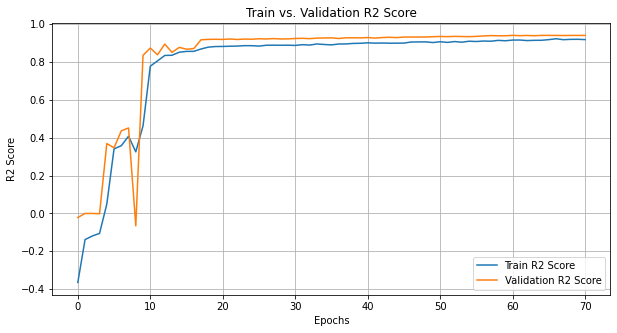

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(best_model_train_r2, label='Train R2 Score')
plt.plot(best_model_val_r2, label='Validation R2 Score')
plt.title('Train vs. Validation R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.grid()
plt.show()

<span style='color:green'>The graph indicates that the model achieves a strong and stable R2 score above 0.8 after the initial epochs, demonstrating effective learning and accurate predictions. The minimal gap between the training and validation curves suggests that the model generalizes well to unseen data without significant overfitting.</span>

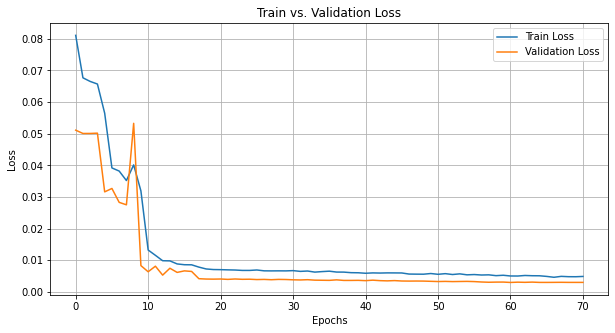

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(best_model_train_losses, label='Train Loss')
plt.plot(best_model_val_losses, label='Validation Loss')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

<span style='color:green'>The graph demonstrates that both training and validation losses decrease rapidly in the initial epochs and stabilize at low levels, indicating effective learning and accurate predictions. The close alignment between the two curves suggests that the model generalizes well to unseen data without significant overfitting. Additionally, the smooth and stable convergence of the loss curves reflects a well-optimized training process, ensuring reliable performance.</span>

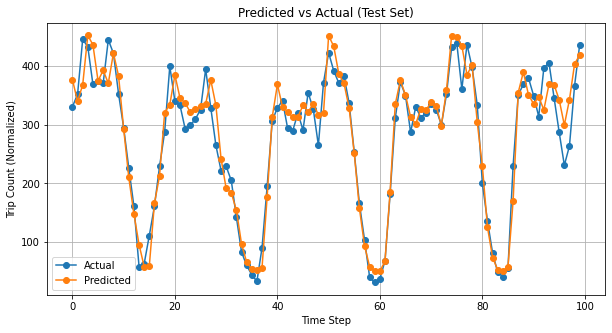

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(test_actuals[:100], label='Actual', marker='o')
plt.plot(test_preds[:100], label='Predicted', marker='o')
plt.title('Predicted vs Actual (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Trip Count (Normalized)')
plt.legend()
plt.grid()
plt.show()

<span style='color:green'>The graph indicates that the predicted values align closely with the actual values, demonstrating that the model has effectively learned the patterns and trends in the data. The consistency between the two curves suggests that the model's predictions are reliable and accurate. While there are a few points of slight deviation, the overall performance appears strong, reflecting the model's ability to generalize well to unseen data.</span>

<span style='color:green'>

### **Dataset Overview**
- The dataset consists of **hourly trip data** including:
  - `pickup_datetime`  
  - `trip_duration`  
  - `passenger_count`  
  - `trip_count`  
- **Time period:** January to June 2016.  
- **Objective:** Forecast hourly `trip_count` using past data.

### **Final LSTM Architecture**
- **Model:** EnhancedLSTMModel (Stacked Bidirectional LSTM).  
- **Layers:**
  - **3 LSTM layers:** Bidirectional with a hidden size of **64** neurons.  
  - **Dropout:** Applied after each LSTM layer and fully connected layer with a rate of **0.2** and in the LSTM layer with a rate of **0.3** to prevent overfitting.  
  - **Normalization:** Used **Layer Normalization** after each fully connected layer to stabilize training.  
  - **Fully Connected Layers:** 
    - `fc1:` 128 neurons.  
    - `fc2:` 64 neurons.  
    - `fc3:` 32 neurons.  
    - `fc_out:` 1 neuron (for final prediction).  
  - **Activation:** ReLU for intermediate layers.  
- **Best Hyperparameters:**
  - **Learning Rate:** 0.0048  
  - **Sequence Length:** 24  
  - **Batch Size:** 32  

### **Results and Analysis**
- **Metrics Used:**
  - **MAE (Mean Absolute Error):** Measures average error magnitude.  
  - **RMSE (Root Mean Square Error):** Penalizes larger errors.  
  - **R-squared Score:** Assesses how well predictions match actual data.  
- **Performance Summary:**
  - Achieved **low validation loss (0.00366)** with the best hyperparameters.  
  - **Test R-squared:** **0.9147** indicating the model explains about **91.47%** of the variance in the test data, which suggests **strong predictive performance**.  
  - **MAE** and **RMSE** values indicate reasonable accuracy, but some deviations in peak hours suggest model limitations.  

**Challenges:**
- **Seasonality and Peaks:** Capturing high variability in peak hours.  
- **Overfitting:** Mitigated using dropout and layer normalization.  
- **Hyperparameter Sensitivity:** Tuning significantly improved loss by focusing on promising regions.  

**Error Patterns:**
- **Under-prediction:** During peak hours (evenings).  
- **Over-prediction:** Early morning hours.  


### **Limitations**
- **Temporal Context:** Limited sequence length (24 hours) may miss long-term dependencies.  
- **Feature Set:** Used only basic features; external data (e.g., weather) could improve predictions.  
- **Training Data:** Imbalanced distribution across different hours may affect performance.  


### **Potential Improvements and Future Work**
1. **Incorporate External Features:**
   - Weather, events, or holidays to enhance temporal context.  

2. **Advanced Architectures:**
   - **Attention Mechanism:** Focus on relevant past time steps.  
   - **GRU Layers:** For faster convergence and reduced complexity.  

3. **Longer Sequence Length:**
   - Experiment with 48 or 72-hour contexts to capture extended patterns.  

4. **Sophisticated Preprocessing:**
   - Handling outliers and scaling more effectively.  
   - Using advanced imputation techniques for missing data.  

5. **Regularization Techniques:**
   - L2 regularization to reduce overfitting further.  

**Summary:**
The model performed reasonably well but has potential for improvement by incorporating more features and exploring advanced architectures like attention mechanisms. The hyperparameter tuning via **Optuna** played a crucial role in optimizing performance efficiently.


</span>